# Melanoma Skin Cancer detection using Deep Neural Networks


In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K


# Data Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import albumentations as alb
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os

# data augmentation techniques in transforms
def transforms(image, normalize = False):
    image = np.array(image)
    transform = alb.Compose([
        alb.OneOf([
            alb.Rotate(limit = 60, border_mode = cv2.BORDER_CONSTANT),
            alb.Rotate(limit = 100, border_mode = cv2.BORDER_CONSTANT),
        ], p = 1),
        alb.HorizontalFlip(), alb.VerticalFlip(),
        alb.CenterCrop(250 ,250, p = 0.4),
        alb.GaussianBlur(p = 0.5),
        alb.Resize(224, 224)
    ])
    x = transform(image = image)['image']
    if normalize:
        x = x / 255
    return x

In [ ]:
# Transforms
folder_benign_train = '/content/drive/MyDrive/melanoma_cancer_dataset-20240420T172335Z-001/melanoma_cancer_dataset/train/benign'
folder_malignant_train = '/content/drive/MyDrive/melanoma_cancer_dataset-20240420T172335Z-001/melanoma_cancer_dataset/train/malignant'

folder_benign_test = '/content/drive/MyDrive/melanoma_cancer_dataset-20240420T172335Z-001/melanoma_cancer_dataset/test/benign'
folder_malignant_test = '/content/drive/MyDrive/melanoma_cancer_dataset-20240420T172335Z-001/melanoma_cancer_dataset/test/malignant'
# /content/drive/MyDrive/melanoma_cancer_dataset-20240420T172335Z-001/melanoma_cancer_dataset
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
X_benign = []
for filename in os.listdir(folder_benign_train):
    X_benign.append(transforms(read(os.path.join(folder_benign_train, filename))))
X_benign = np.array(X_benign, dtype='uint8')

X_malignant = []
for filename in os.listdir(folder_malignant_train):
    X_malignant.append(transforms(read(os.path.join(folder_malignant_train, filename))))
X_malignant = np.array(X_malignant, dtype='uint8')

# Load in testing pictures
X_benign_test = []
for filename in os.listdir(folder_benign_test):
    X_benign_test.append(transforms(read(os.path.join(folder_benign_test, filename))))
X_benign_test = np.array(X_benign_test, dtype='uint8')

X_malignant_test = []
for filename in os.listdir(folder_malignant_test):
    X_malignant_test.append(transforms(read(os.path.join(folder_malignant_test, filename))))
X_malignant_test = np.array(X_malignant_test, dtype='uint8')

In [ ]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis=0)
y_train = np.concatenate((y_benign, y_malignant), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [ ]:
# Transforms

# np.save("/content/drive/MyDrive/Machine Learning/numpys/transforms/X_train.npy", X_train)
# np.save("/content/drive/MyDrive/Machine Learning/numpys/transforms/y_train.npy", y_train)
# np.save("/content/drive/MyDrive/Machine Learning/numpys/transforms/X_test.npy", X_test)
# np.save("/content/drive/MyDrive/Machine Learning/numpys/transforms/y_test.npy", y_test)

X_train = np.load("/content/drive/MyDrive/Machine Learning/numpys/transforms/X_train.npy")
y_train = np.load("/content/drive/MyDrive/Machine Learning/numpys/transforms/y_train.npy")

X_test = np.load("/content/drive/MyDrive/Machine Learning/numpys/transforms/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Machine Learning/numpys/transforms/y_test.npy")

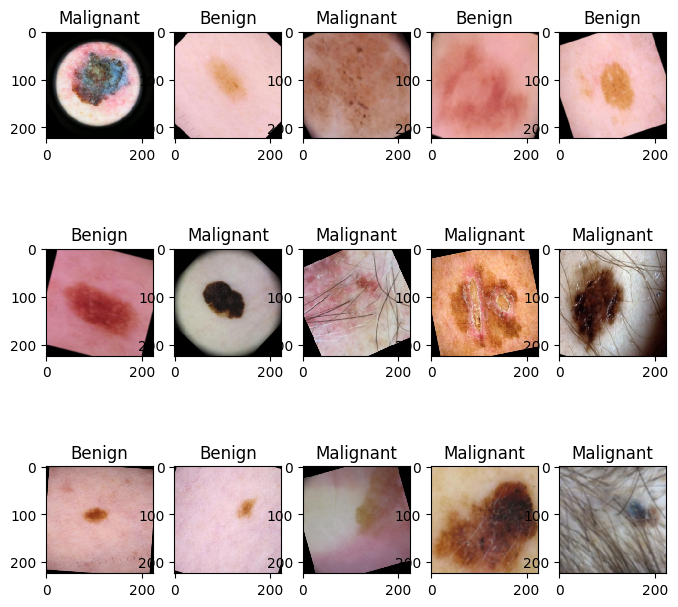

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

#VGG16 model with SVM as output layer​

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Flatten, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50
from sklearn.svm import SVC
from keras.callbacks import ReduceLROnPlateau

input_shape = (224, 224, 3)
lr = 0.003
epochs = 30
batch_size = 64

learning_rate_reduction = ReduceLROnPlateau(
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=1e-7
)

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'
)

# Flatten layer directly after the VGG16 base
flat = Flatten()(base_model.output)

# No need for Lambda layer for normalization

svm_output = Dense(1, activation='sigmoid')(flat)

combined_model = Model(inputs=base_model.input, outputs=svm_output)

combined_model.compile(
    optimizer=Adam(lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
combined_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/checkpoints/VGG16/vgg16-model-noscatter.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

Epoch 1/15
121/121 [==============================] - ETA: 0s - loss: 10430.2568 - accuracy: 0.5675
Epoch 1: val_loss improved from inf to 0.60108, saving model to /content/drive/MyDrive/checkpoints/VGG16/vgg16-model-noscatter.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 146s 878ms/step - loss: 10430.2568 - accuracy: 0.5675 - val_loss: 0.6011 - val_accuracy: 0.6455 - lr: 0.0030
Epoch 2/15
121/121 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.6763
Epoch 2: val_loss improved from 0.60108 to 0.57050, saving model to /content/drive/MyDrive/checkpoints/VGG16/vgg16-model-noscatter.h5
121/121 [==============================] - 104s 859ms/step - loss: 0.5816 - accuracy: 0.6763 - val_loss: 0.5705 - val_accuracy: 0.6892 - lr: 0.0030
Epoch 3/15
121/121 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7128
Epoch 3: val_loss improved from 0.57050 to 0.48916, saving model to /content/drive/MyDrive/checkpoints/VGG16/vgg16-model-noscatter.h5
121/121 [==============================] - 105s 866ms/step - loss: 0.5408 - accuracy: 0.7128 - val_loss: 0.4892 - val_accuracy: 0.8126 - lr: 0.0030
Epoch 4/15
121/121 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.7

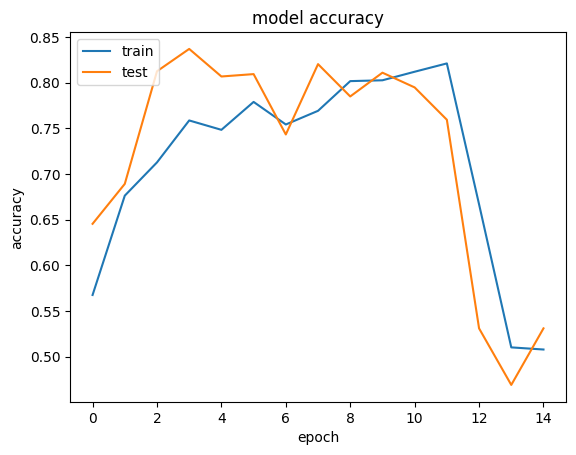

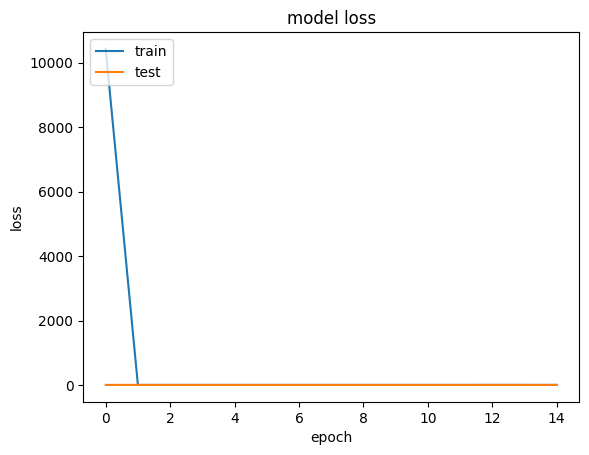

In [ ]:

history_combined = combined_model.fit(X_train, y_train, validation_split=0.2,
                    epochs= 15, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction, checkpoint]
                   )

print(history_combined.history.keys())
# summarize history for accuracy
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = combined_model.predict(X_test)
# print(np.mean(y_pred))
threshold = np.mean(y_pred)
y_pred_binary = (y_pred > threshold).astype(int)
# print(y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

26/26 [==============================] - 3s 106ms/step
Accuracy: 0.5938650306748466
Precision: 0.6107470511140236
Recall: 0.932
F1 Score: 0.7379255740300872
AUC Score: 0.4945714285714286


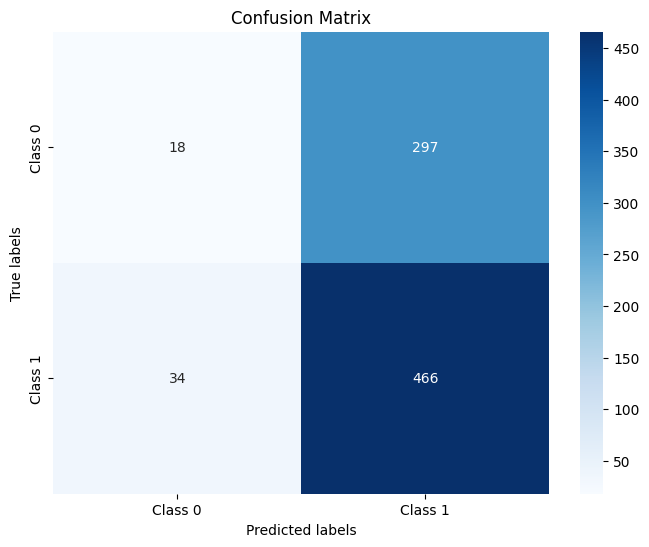

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#Resnet 50 with SVM as Output layer​

In [ ]:
# No scatter
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Flatten, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50
from sklearn.svm import SVC
from keras.callbacks import ReduceLROnPlateau

input_shape = (224, 224, 3)
lr = 0.003
epochs = 50
batch_size = 64

learning_rate_reduction = ReduceLROnPlateau(
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=1e-7
)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'
)

# Flatten layer directly after the ResNet50 base
flat = Flatten()(base_model.output)

# No need for Lambda layer for normalization

svm_output = Dense(1, activation='sigmoid')(flat)

combined_model = Model(inputs=base_model.input, outputs=svm_output)

combined_model.compile(
    optimizer=Adam(lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)




94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-model-noscatter.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

In [ ]:
import pickle
with open('/content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-tran-noscatter-his', 'wb') as file_pi:
    pickle.dump(history_combined.history, file_pi)

In [ ]:
history_combined = combined_model.fit(X_train, y_train, validation_split=0.2,
                    epochs= 25, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction, checkpoint]
                   )


Epoch 1/25
121/121 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.7984
Epoch 1: val_loss improved from inf to 213.04333, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-model-noscatter.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 123s 685ms/step - loss: 0.4982 - accuracy: 0.7984 - val_loss: 213.0433 - val_accuracy: 0.4690 - lr: 0.0030
Epoch 2/25
121/121 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8512
Epoch 2: val_loss improved from 213.04333 to 26.61919, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-model-noscatter.h5
121/121 [==============================] - 86s 709ms/step - loss: 0.3558 - accuracy: 0.8512 - val_loss: 26.6192 - val_accuracy: 0.4789 - lr: 0.0030
Epoch 3/25
121/121 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8511
Epoch 3: val_loss improved from 26.61919 to 1.66084, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-model-noscatter.h5
121/121 [==============================] - 93s 767ms/step - loss: 0.3482 - accuracy: 0.8511 - val_loss: 1.6608 - val_accuracy: 0.6429 - lr: 0.0030
Epoch 4/25
121/121 [=========================

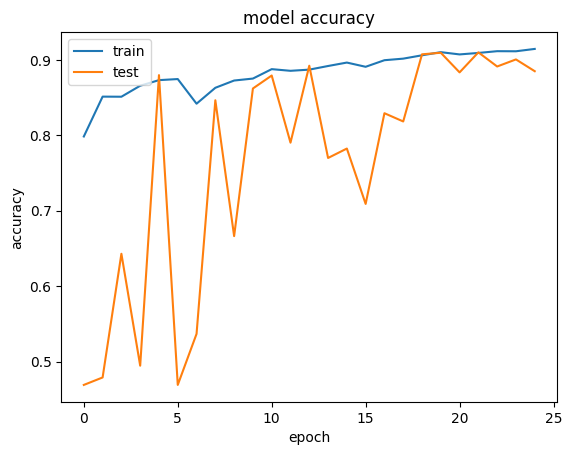

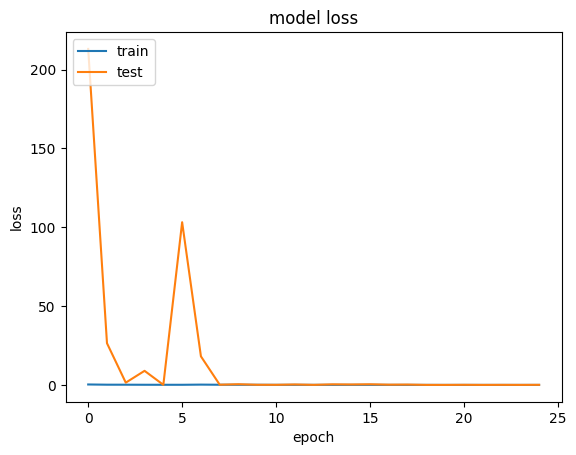

In [ ]:
# with open('/content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-tran-noscatter-his', "rb") as file_pi:
#     history_combined = pickle.load(file_pi)

# list all data in history
# print(history_combined.keys())
# summarize history for accuracy
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
hybrid_model = load_model('/content/drive/MyDrive/Machine Learning/checkpoints/resnet50/resnet50-model-noscatter.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = combined_model.predict(X_test)
# print(np.mean(y_pred))
threshold = np.mean(y_pred)
y_pred_binary = (y_pred > threshold).astype(int)
# print(y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

26/26 [==============================] - 7s 137ms/step
Accuracy: 0.8846625766871166
Precision: 0.9375
Recall: 0.87
F1 Score: 0.9024896265560166
AUC Score: 0.888968253968254


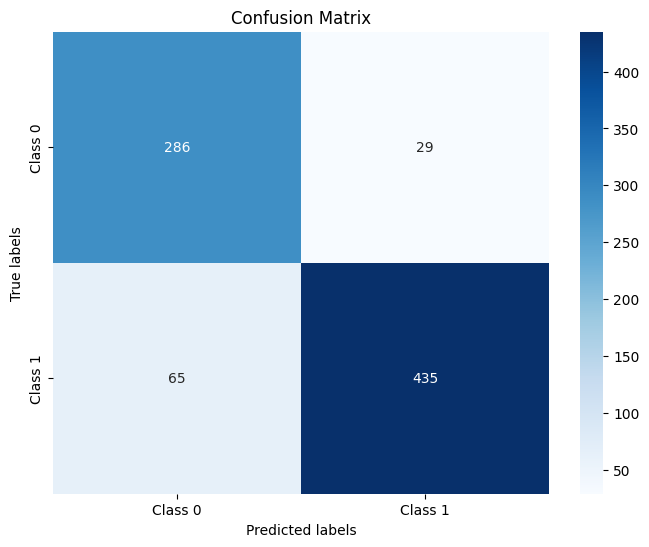

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#  Shallow Hybrid (CNN+SVM) Model​

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def build_cnn(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
              init='normal', activ='relu', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=input_shape,
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                     activation=activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))

    return model

def build_hybrid_model(cnn_model, svm_c=1.0, svm_kernel='rbf'):
    input_shape = cnn_model.layers[0].input_shape[1:]
    last_layer_output = cnn_model.layers[-2].output

    # Build SVM model
    svm_model = make_pipeline(StandardScaler(), SVC(C=svm_c, kernel=svm_kernel))

    # Create a hybrid model
    hybrid_model = Sequential()
    hybrid_model.add(cnn_model)
    hybrid_model.add(Dense(1, activation='sigmoid'))  # Output layer for SVM

    # Compile the hybrid model
    hybrid_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return hybrid_model

# Build CNN model
cnn_model = build_cnn()

# Build Hybrid model
hybrid_model = build_hybrid_model(cnn_model)



In [ ]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 56, 56, 64)       

In [ ]:
hybrid_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               25728960  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25729089 (98.15 MB)
Trainable params: 25729089 (98.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

Epoch 1/50
120/121 [============================>.] - ETA: 0s - loss: 247.6592 - accuracy: 0.5210
Epoch 1: val_loss improved from inf to 0.68568, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model.h5
121/121 [==============================] - 44s 348ms/step - loss: 247.5308 - accuracy: 0.5211 - val_loss: 0.6857 - val_accuracy: 0.5424 - lr: 0.0010
Epoch 2/50
120/121 [============================>.] - ETA: 0s - loss: 0.7330 - accuracy: 0.5385
Epoch 2: val_loss improved from 0.68568 to 0.67696, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model.h5
121/121 [==============================] - 47s 391ms/step - loss: 0.7330 - accuracy: 0.5385 - val_loss: 0.6770 - val_accuracy: 0.5903 - lr: 0.0010
Epoch 3/50
120/121 [============================>.] - ETA: 0s - loss: 0.7051 - accuracy: 0.5766
Epoch 3: val_loss improved from 0.67696 to 0.66562, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybri

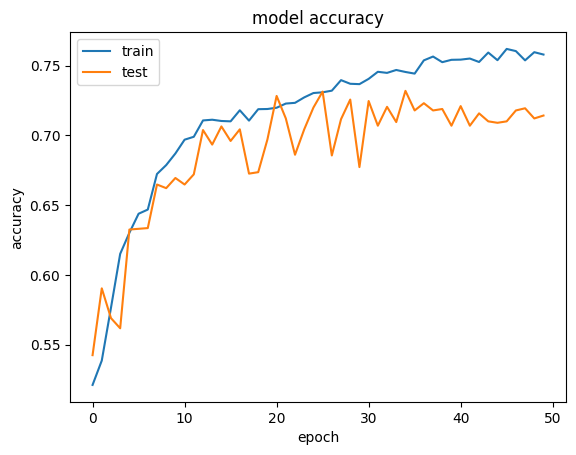

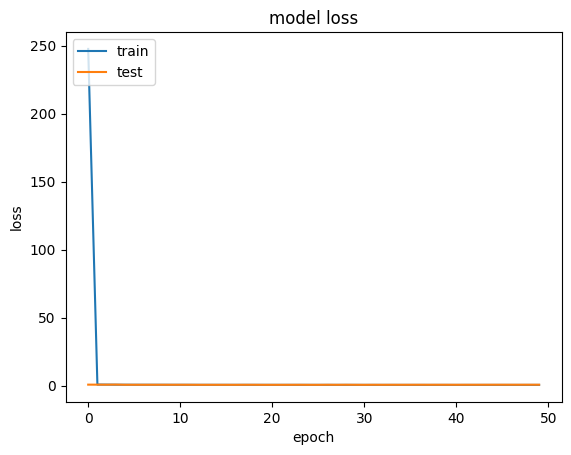

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

history_combined = hybrid_model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction, checkpoint]
                   )
# import pickle
# with open('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-tran-his', 'wb') as file_pi:
#     pickle.dump(history_combined.history, file_pi)

# list all data in history
# print(history_combined.history.keys())
# summarize history for accuracy
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

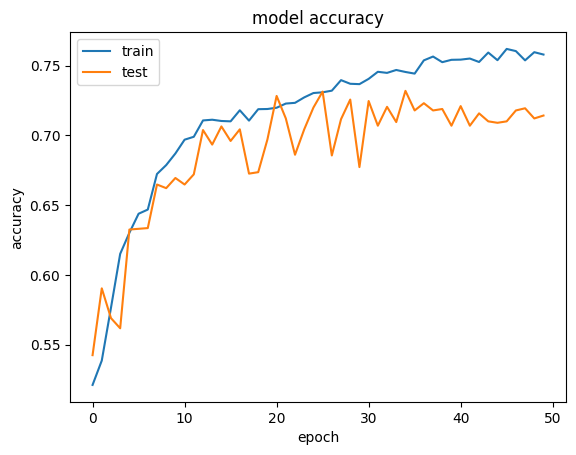

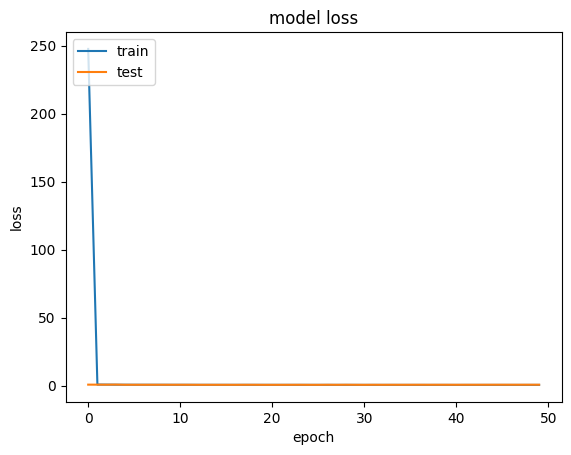

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-tran-his (1)', "rb") as file_pi:
#     history_combined = pickle.load(file_pi)

# list all data in history
# print(history_combined.keys())
# summarize history for accuracy
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
hybrid_model = load_model('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid-model.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = hybrid_model.predict(X_test)
# print(np.mean(y_pred))
threshold = np.mean(y_pred)
y_pred_binary = (y_pred > threshold).astype(int)
# print(y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

26/26 [==============================] - 2s 42ms/step
Accuracy: 0.746031746031746
Precision: 0.8924731182795699
Recall: 0.664
F1 Score: 0.7614678899082569
AUC Score: 0.7693040752351098


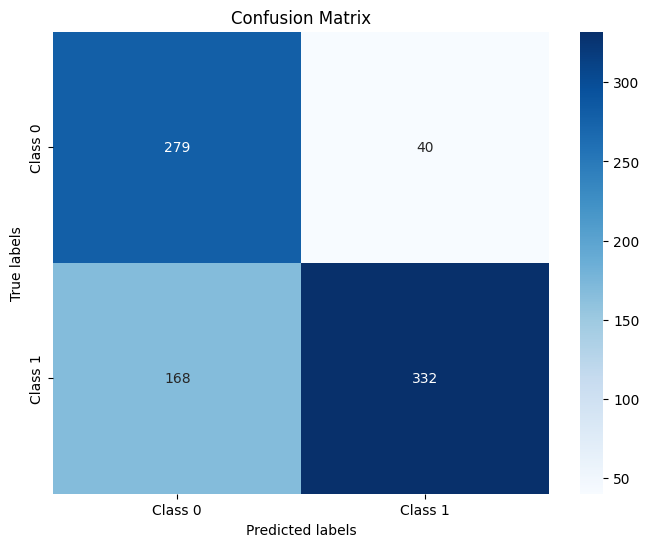

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Complex Hybrid (CNN+ SVM)Model​


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.svm import SVC
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

def build_cnn_complex(input_shape=(224, 224, 3), lr=1e-3, num_classes=2,
                      init='he_normal', activ='relu', optim='adam'):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=input_shape,
                     activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                     activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same',
                     activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=(3, 3), padding='same',
                     activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation=activ, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))

    return model


def build_hybrid_model(cnn_model, svm_c=1.0, svm_kernel='rbf'):
    input_shape = cnn_model.layers[0].input_shape[1:]

    # Create a hybrid model
    hybrid_model = Sequential()
    hybrid_model.add(cnn_model)
    hybrid_model.add(Dense(1, activation='linear'))  # Output layer for SVM

    # Compile the hybrid model
    hybrid_model.compile(optimizer=Adam(lr=1e-4), loss='hinge', metrics=['accuracy'])

    return hybrid_model

# Build CNN model
cnn_model = build_cnn_complex()

# Build Hybrid model
hybrid_model = build_hybrid_model(cnn_model)



In [ ]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)    

In [ ]:
hybrid_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128)               104912896 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 104913025 (400.21 MB)
Trainable params: 104908033 (400.19 MB)
Non-trainable params: 4992 (19.50 KB)
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model-complex.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.8129
Epoch 1: val_loss improved from inf to 2.00585, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model-complex.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 142s 1s/step - loss: 0.5211 - accuracy: 0.8129 - val_loss: 2.0058 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8429
Epoch 2: val_loss improved from 2.00585 to 0.75349, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model-complex.h5
121/121 [==============================] - 129s 1s/step - loss: 0.3913 - accuracy: 0.8429 - val_loss: 0.7535 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8433
Epoch 3: val_loss improved from 0.75349 to 0.37149, saving model to /content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model-complex.h5
121/121 [==============================] - 117s 974ms/step - loss: 0.3845 - accuracy: 0.8433 - val_loss: 0.3715 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - ETA: 0s - loss

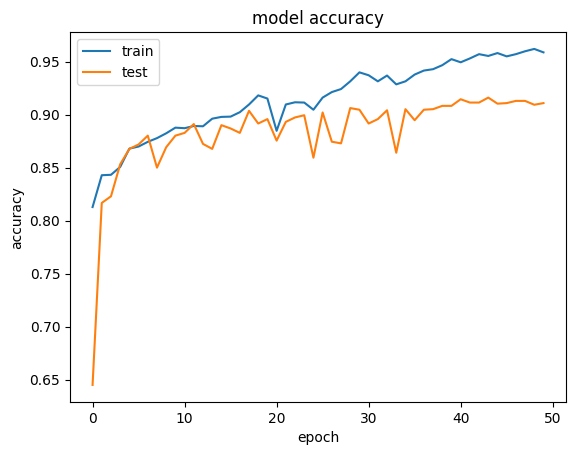

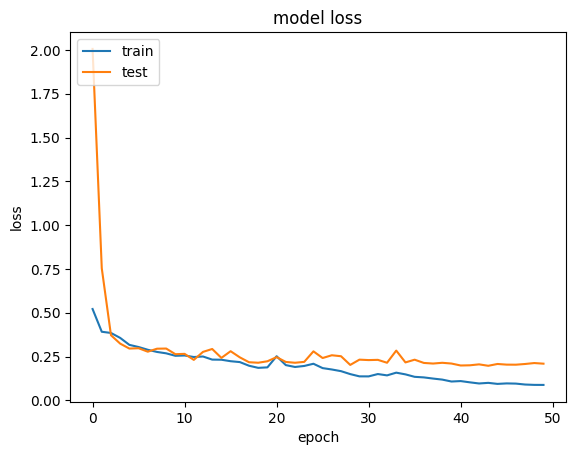

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

history_combined = hybrid_model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1,
                    callbacks=[learning_rate_reduction, checkpoint]
                   )
import pickle
with open('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-tran-complex-his', 'wb') as file_pi:
    pickle.dump(history_combined.history, file_pi)

# list all data in history
print(history_combined.history.keys())
# summarize history for accuracy
plt.plot(history_combined.history['accuracy'])
plt.plot(history_combined.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

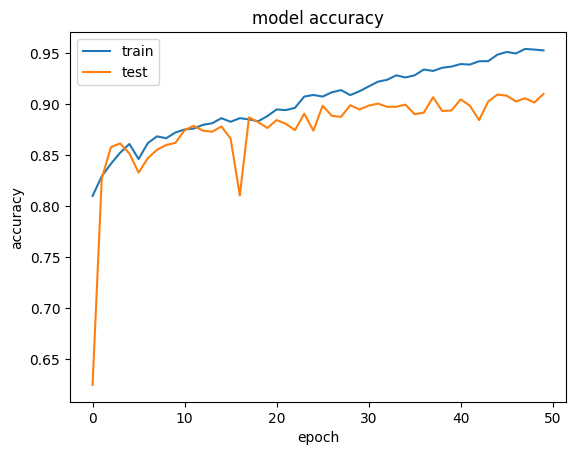

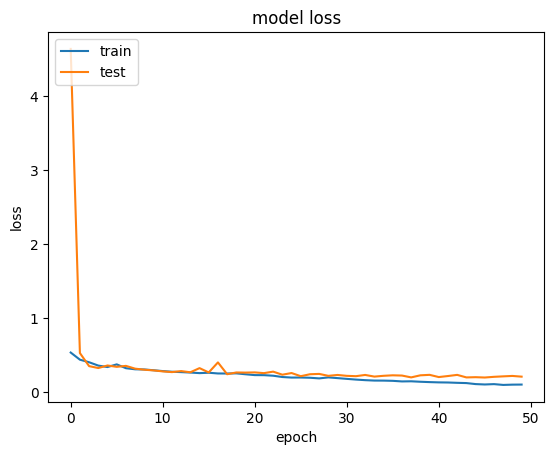

In [ ]:
import pickle

with open('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-tran-complex-his', "rb") as file_pi:
    history_combined = pickle.load(file_pi)

# summarize history for accuracy
plt.plot(history_combined['accuracy'])
plt.plot(history_combined['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_combined['loss'])
plt.plot(history_combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
hybrid_model = load_model('/content/drive/MyDrive/Machine Learning/checkpoints/hybrid/hybrid-model-complex.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = hybrid_model.predict(X_test)
# print(np.mean(y_pred))
threshold = np.mean(y_pred)
y_pred_binary = (y_pred > threshold).astype(int)
# print(y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

26/26 [==============================] - 5s 86ms/step
Accuracy: 0.8717948717948718
Precision: 0.9561200923787528
Recall: 0.828
F1 Score: 0.887459807073955
AUC Score: 0.884219435736677


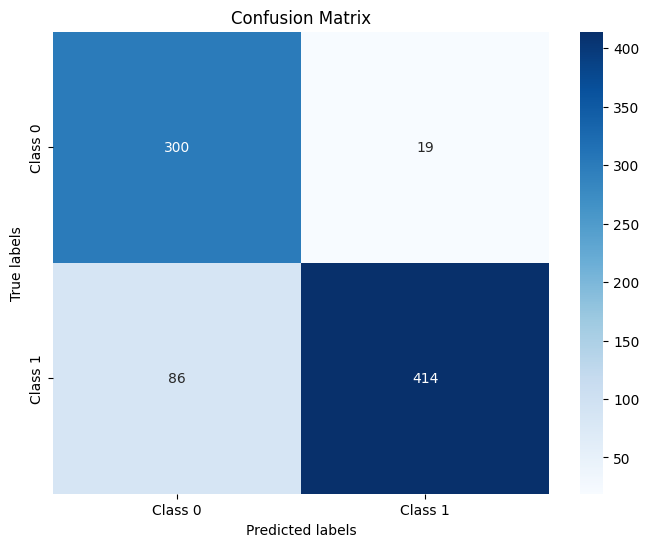

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()